In [112]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enigma/train.csv
/kaggle/input/enigma/test.csv


In [113]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [329]:
train=pd.read_csv("/kaggle/input/enigma/train.csv")
test=pd.read_csv("/kaggle/input/enigma/test.csv")

In [273]:
train

,ID,LIMIT_BAL,SEX,EDUCATION,MARITAL_STATUS,AGE,INSTALLMENT_1,INSTALLMENT_2,INSTALLMENT_3,INSTALLMENT_AMT_1,INSTALLMENT_AMT_2,INSTALLMENT_AMT_3,INSTALLMENT_PAID_1,INSTALLMENT_PAID_2,INSTALLMENT_PAID_3,def_pay
0,12194,220000.0,FEMALE,graduate school,MARRIED,54,1,0,0,0.0,0.0,788.0,0.0,788.0,0.0,0
1,7068,90000.0,FEMALE,graduate school,SINGLE,30,2,2,3,750.0,750.0,750.0,0.0,0.0,0.0,0
2,1446,80000.0,FEMALE,university,SINGLE,25,2,3,2,69602.0,67930.0,72205.0,0.0,6000.0,2700.0,0
3,318,260000.0,FEMALE,high school,MARRIED,53,1,0,0,0.0,165.0,526.0,165.0,526.0,452.0,0
4,13732,30000.0,FEMALE,university,SINGLE,23,0,0,0,25287.0,26501.0,30300.0,2011.0,5000.0,868.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20996,5187,230000.0,MALE,graduate school,SINGLE,39,0,0,0,38395.0,39943.0,20650.0,2500.0,2000.0,0.0,0
20997,4825,200000.0,MALE,graduate school,MARRIED,31,0,0,0,160292.0,119080.0,113723.0,6036.0,4002.0,4005.0,0
20998,29044,50000.0,FEMALE,university,MARRIED,50,0,0,0,32570.0,34713.0,39803.0,3000.0,6000.0,3000.0,0
20999,28154,210000.0,FEMALE,graduate school,MARRIED,34,0,0,0,73329.0,74261.0,75602.0,2700.0,3500.0,3300.0,0


In [165]:
train["INSTALLMENT_1"].unique()

array([ 1,  2,  0, -1, -2,  3,  4,  5,  8,  6,  7])

In [166]:
train[['INSTALLMENT_1', 'INSTALLMENT_2', 'INSTALLMENT_3']].describe()

,INSTALLMENT_1,INSTALLMENT_2,INSTALLMENT_3
count,21000.000000,21000.000000,21000.000000
mean,-0.011381,-0.129619,-0.164714
std,1.131404,1.203697,1.201243
min,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,8.000000,7.000000,8.000000


In [118]:
train.SEX.value_counts()

SEX
FEMALE    12699
MALE       8301
Name: count, dtype: int64

In [119]:
train.EDUCATION.value_counts()

EDUCATION
university         9751
graduate school    7485
high school        3433
Unknown             331
Name: count, dtype: int64

In [120]:
train.MARITAL_STATUS.value_counts()

MARITAL_STATUS
SINGLE     11117
MARRIED     9624
3            221
0             38
Name: count, dtype: int64

In [330]:
train.loc[train.MARITAL_STATUS == "0", 'MARITAL_STATUS'] = "3"
train.MARITAL_STATUS.value_counts()

MARITAL_STATUS
SINGLE     11117
MARRIED     9624
3            259
Name: count, dtype: int64

In [331]:
train = train.rename(columns={'DEFAULT.PAYMENT.NEXT.MONTH': 'def_pay'})
train.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARITAL_STATUS,AGE,INSTALLMENT_1,INSTALLMENT_2,INSTALLMENT_3,INSTALLMENT_AMT_1,INSTALLMENT_AMT_2,INSTALLMENT_AMT_3,INSTALLMENT_PAID_1,INSTALLMENT_PAID_2,INSTALLMENT_PAID_3,def_pay
0,12194,220000.0,FEMALE,graduate school,MARRIED,54,1,-2,-1,0.0,0.0,788.0,0.0,788.0,0.0,0
1,7068,90000.0,FEMALE,graduate school,SINGLE,30,2,2,3,750.0,750.0,750.0,0.0,0.0,0.0,0
2,1446,80000.0,FEMALE,university,SINGLE,25,2,3,2,69602.0,67930.0,72205.0,0.0,6000.0,2700.0,0
3,318,260000.0,FEMALE,high school,MARRIED,53,1,-1,-1,0.0,165.0,526.0,165.0,526.0,452.0,0
4,13732,30000.0,FEMALE,university,SINGLE,23,0,0,0,25287.0,26501.0,30300.0,2011.0,5000.0,868.0,0


In [123]:
train.INSTALLMENT_1.value_counts()

INSTALLMENT_1
 0    10240
-1     3975
 1     2610
-2     1942
 2     1901
 3      231
 4       55
 5       17
 8       15
 6        8
 7        6
Name: count, dtype: int64

In [332]:
train['INSTALLMENT_1'] = train['INSTALLMENT_1'].replace([-1, -2], 0)
train['INSTALLMENT_2'] = train['INSTALLMENT_2'].replace([-1, -2], 0)
train['INSTALLMENT_3'] = train['INSTALLMENT_3'].replace([-1, -2], 0)

In [333]:
train.INSTALLMENT_1.value_counts()

INSTALLMENT_1
0    16157
1     2610
2     1901
3      231
4       55
5       17
8       15
6        8
7        6
Name: count, dtype: int64

In [334]:
train.def_pay.sum() / len(train.def_pay)

0.22342857142857142

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
%matplotlib inline

In [128]:
gender = train.groupby(['SEX', 'def_pay']).size().unstack(1)
gender

def_pay,0,1
SEX,,
FEMALE,10048,2651
MALE,6260,2041


<Axes: xlabel='SEX'>

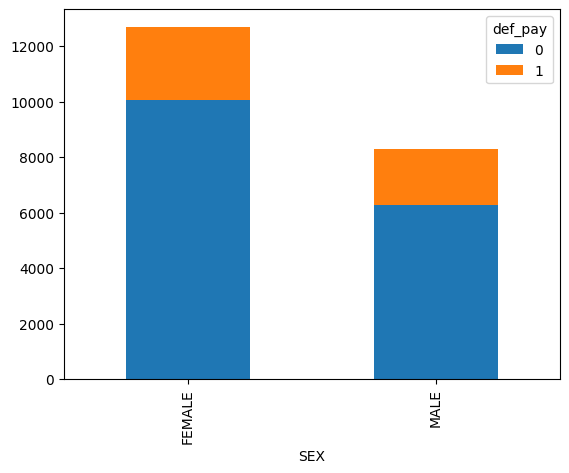

In [129]:
gender.plot(kind='bar', stacked = True)

In [130]:
gender['perc'] = (gender[1]/(gender[0] + gender[1])) 
gender


def_pay,0,1,perc
SEX,,,
FEMALE,10048,2651,0.208757
MALE,6260,2041,0.245874


In [131]:
train

,ID,LIMIT_BAL,SEX,EDUCATION,MARITAL_STATUS,AGE,INSTALLMENT_1,INSTALLMENT_2,INSTALLMENT_3,INSTALLMENT_AMT_1,INSTALLMENT_AMT_2,INSTALLMENT_AMT_3,INSTALLMENT_PAID_1,INSTALLMENT_PAID_2,INSTALLMENT_PAID_3,def_pay
0,12194,220000.0,FEMALE,graduate school,MARRIED,54,1,0,0,0.0,0.0,788.0,0.0,788.0,0.0,0
1,7068,90000.0,FEMALE,graduate school,SINGLE,30,2,2,3,750.0,750.0,750.0,0.0,0.0,0.0,0
2,1446,80000.0,FEMALE,university,SINGLE,25,2,3,2,69602.0,67930.0,72205.0,0.0,6000.0,2700.0,0
3,318,260000.0,FEMALE,high school,MARRIED,53,1,0,0,0.0,165.0,526.0,165.0,526.0,452.0,0
4,13732,30000.0,FEMALE,university,SINGLE,23,0,0,0,25287.0,26501.0,30300.0,2011.0,5000.0,868.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,16350,210000.0,FEMALE,graduate school,SINGLE,37,0,0,0,349.0,10128.0,19631.0,10152.0,19631.0,23906.0,1
20996,5187,230000.0,MALE,graduate school,SINGLE,39,0,0,0,38395.0,39943.0,20650.0,2500.0,2000.0,0.0,0
20997,4825,200000.0,MALE,graduate school,MARRIED,31,0,0,0,160292.0,119080.0,113723.0,6036.0,4002.0,4005.0,0
20998,29044,50000.0,FEMALE,university,MARRIED,50,0,0,0,32570.0,34713.0,39803.0,3000.0,6000.0,3000.0,0


In [336]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

In [337]:
placeholder_row = pd.DataFrame({'ID': [train['ID'].mode()[0]], 
                                'LIMIT_BAL': [train['LIMIT_BAL'].mode()[0]], 
                                'SEX': [train['SEX'].mode()[0]],  
                                'EDUCATION': [train['EDUCATION'].mode()[0]],
                                'MARITAL_STATUS': [train['MARITAL_STATUS'].mode()[0]],
                                'AGE': [train['AGE'].mode()[0]],
                                'INSTALLMENT_1': [train['INSTALLMENT_1'].mode()[0]],
                                'INSTALLMENT_2': [8],  # The missing category
                                'INSTALLMENT_3': [train['INSTALLMENT_3'].mode()[0]],
                                'INSTALLMENT_AMT_1': [train['INSTALLMENT_AMT_1'].mode()[0]],
                                'INSTALLMENT_AMT_2': [train['INSTALLMENT_AMT_2'].mode()[0]],
                                'INSTALLMENT_AMT_3': [train['INSTALLMENT_AMT_3'].mode()[0]],
                                'INSTALLMENT_PAID_1': [train['INSTALLMENT_PAID_1'].mode()[0]],
                                'INSTALLMENT_PAID_2': [train['INSTALLMENT_PAID_2'].mode()[0]],
                                'INSTALLMENT_PAID_3': [train['INSTALLMENT_PAID_3'].mode()[0]],
                                'def_pay': [train['def_pay'].mode()[0]],
                               })

In [338]:
train = pd.concat([train, placeholder_row], ignore_index=True)

In [339]:
encode_train = encoder.fit_transform(train[['SEX', 'EDUCATION',"MARITAL_STATUS",'INSTALLMENT_1','INSTALLMENT_2',"INSTALLMENT_3"]])
train_enc = pd.DataFrame(encode_train, columns=encoder.get_feature_names_out(['SEX', 'EDUCATION',"MARITAL_STATUS",'INSTALLMENT_1','INSTALLMENT_2',"INSTALLMENT_3"]))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [340]:
train_enc

,SEX_FEMALE,SEX_MALE,EDUCATION_Unknown,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_university,MARITAL_STATUS_3,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,INSTALLMENT_1_0,...,INSTALLMENT_2_8,INSTALLMENT_3_0,INSTALLMENT_3_1,INSTALLMENT_3_2,INSTALLMENT_3_3,INSTALLMENT_3_4,INSTALLMENT_3_5,INSTALLMENT_3_6,INSTALLMENT_3_7,INSTALLMENT_3_8
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20996,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20997,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20998,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20999,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [341]:
train_woc=train.drop(['SEX', 'EDUCATION',"MARITAL_STATUS",'INSTALLMENT_1','INSTALLMENT_2',"INSTALLMENT_3"], axis=1)
final_train = pd.concat([train_woc, train_enc], axis=1)
final_train

,ID,LIMIT_BAL,AGE,INSTALLMENT_AMT_1,INSTALLMENT_AMT_2,INSTALLMENT_AMT_3,INSTALLMENT_PAID_1,INSTALLMENT_PAID_2,INSTALLMENT_PAID_3,def_pay,...,INSTALLMENT_2_8,INSTALLMENT_3_0,INSTALLMENT_3_1,INSTALLMENT_3_2,INSTALLMENT_3_3,INSTALLMENT_3_4,INSTALLMENT_3_5,INSTALLMENT_3_6,INSTALLMENT_3_7,INSTALLMENT_3_8
0,12194,220000.0,54,0.0,0.0,788.0,0.0,788.0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7068,90000.0,30,750.0,750.0,750.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1446,80000.0,25,69602.0,67930.0,72205.0,0.0,6000.0,2700.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,318,260000.0,53,0.0,165.0,526.0,165.0,526.0,452.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13732,30000.0,23,25287.0,26501.0,30300.0,2011.0,5000.0,868.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20996,5187,230000.0,39,38395.0,39943.0,20650.0,2500.0,2000.0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20997,4825,200000.0,31,160292.0,119080.0,113723.0,6036.0,4002.0,4005.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20998,29044,50000.0,50,32570.0,34713.0,39803.0,3000.0,6000.0,3000.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20999,28154,210000.0,34,73329.0,74261.0,75602.0,2700.0,3500.0,3300.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [363]:
final_train['TOTAL_BILL_AMOUNT'] = final_train['INSTALLMENT_AMT_1'] + final_train['INSTALLMENT_AMT_2'] + final_train['INSTALLMENT_AMT_3']
final_train['TOTAL_PAID_AMOUNT'] = final_train['INSTALLMENT_PAID_1'] + final_train['INSTALLMENT_PAID_2'] + final_train['INSTALLMENT_PAID_3']
final_train

,ID,LIMIT_BAL,AGE,INSTALLMENT_AMT_1,INSTALLMENT_AMT_2,INSTALLMENT_AMT_3,INSTALLMENT_PAID_1,INSTALLMENT_PAID_2,INSTALLMENT_PAID_3,def_pay,...,INSTALLMENT_3_1,INSTALLMENT_3_2,INSTALLMENT_3_3,INSTALLMENT_3_4,INSTALLMENT_3_5,INSTALLMENT_3_6,INSTALLMENT_3_7,INSTALLMENT_3_8,TOTAL_BILL_AMOUNT,TOTAL_PAID_AMOUNT
0,12194,220000.0,54,0.0,0.0,788.0,0.0,788.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,788.0,788.0
1,7068,90000.0,30,750.0,750.0,750.0,0.0,0.0,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2250.0,0.0
2,1446,80000.0,25,69602.0,67930.0,72205.0,0.0,6000.0,2700.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,209737.0,8700.0
3,318,260000.0,53,0.0,165.0,526.0,165.0,526.0,452.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,691.0,1143.0
4,13732,30000.0,23,25287.0,26501.0,30300.0,2011.0,5000.0,868.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82088.0,7879.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20996,5187,230000.0,39,38395.0,39943.0,20650.0,2500.0,2000.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98988.0,4500.0
20997,4825,200000.0,31,160292.0,119080.0,113723.0,6036.0,4002.0,4005.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,393095.0,14043.0
20998,29044,50000.0,50,32570.0,34713.0,39803.0,3000.0,6000.0,3000.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107086.0,12000.0
20999,28154,210000.0,34,73329.0,74261.0,75602.0,2700.0,3500.0,3300.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,223192.0,9500.0


In [376]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame and 'TOTAL_BILL_AMOUNT' is the column
scaler = MinMaxScaler()
final_train[['TOTAL_BILL_AMOUNT',"TOTAL_PAID_AMOUNT"]] = scaler.fit_transform(final_train[['TOTAL_BILL_AMOUNT',"TOTAL_PAID_AMOUNT"]])


In [244]:
final_train['TOTAL_BILL_AMOUNT'].describe()

count    2.100100e+04
mean     1.482756e+05
std      2.100120e+05
min     -6.127500e+04
25%      1.309700e+04
50%      6.695500e+04
75%      1.924990e+05
max      2.483462e+06
Name: TOTAL_BILL_AMOUNT, dtype: float64

In [377]:
X=final_train.drop(['def_pay','ID'],axis=1)
Y=final_train['def_pay']

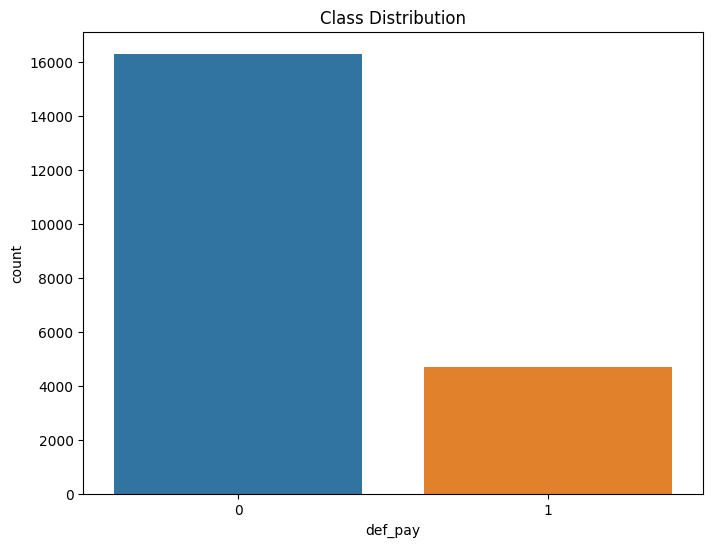

In [365]:
import seaborn as sns

# Assuming 'Y' is the target column in your DataFrame named 'df'
plt.figure(figsize=(8, 6))
sns.countplot(x='def_pay', data=final_train)
plt.title('Class Distribution')
plt.show()


In [366]:
from sklearn.model_selection import train_test_split

In [460]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=32)

In [461]:
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
import numpy as np

In [462]:
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

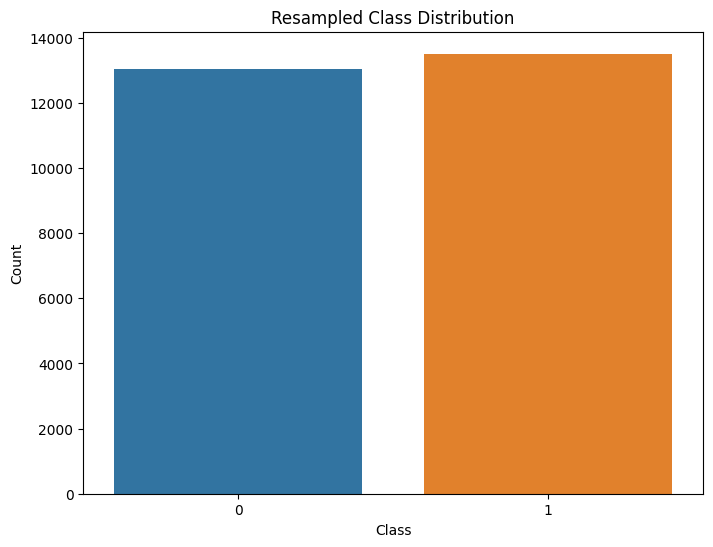

In [395]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [396]:
xgmodel=XGBClassifier(n_estimators=100,class_weight="balanced",random_state=42)
xgmodel.fit(X_resampled,y_resampled)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:12:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [397]:
y_pred=xgmodel.predict(X_test)

In [398]:
f1 = f1_score(y_test, y_pred)
f1

0.4944408109875736

In [391]:
rmodel=RandomForestClassifier(n_estimators = 200, class_weight = "balanced",random_state=32)

In [319]:
rmodel.fit(X_resampled,y_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [320]:
y_pred=rmodel.predict(X_test)

In [321]:
f1 = f1_score(y_test, y_pred)
f1

0.4830729166666667

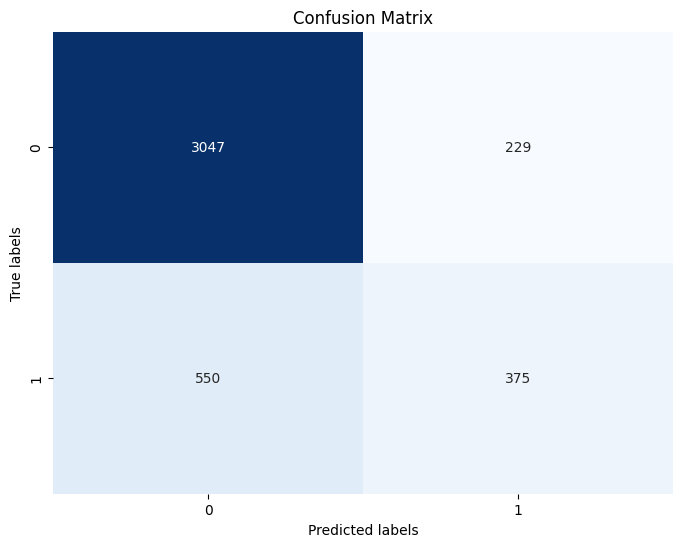

In [272]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13510, number of negative: 13054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6884
[LightGBM] [Info] Number of data points in the train set: 26564, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508583 -> initscore=0.034336
[LightGBM] [Info] Start training from score 0.034336
F1 Score: 0.5199216198563031


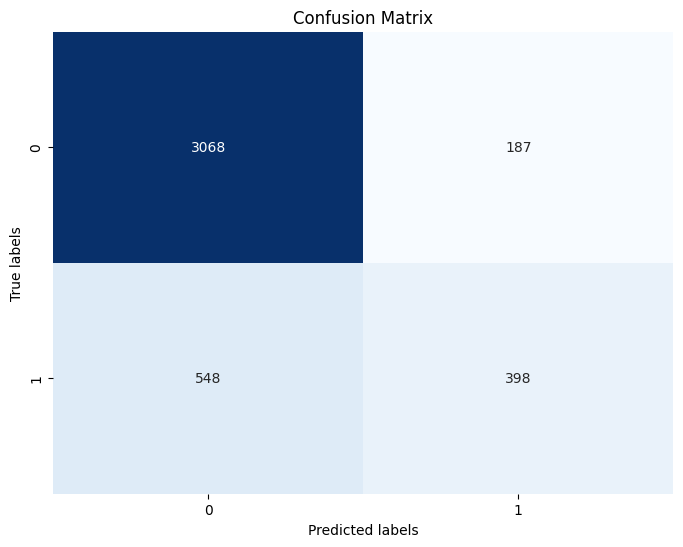

In [430]:
import lightgbm as lgb
model = lgb.LGBMClassifier(random_state=42,learning_rate= 0.01, max_depth= 3, n_estimators= 300)

# Fit the model on resampled data
model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Print F1 score
print("F1 Score:", f1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}  0.79
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Define the LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    # Add more hyperparameters as needed
}
scorer = make_scorer(f1_score)
# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring=scorer)
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [463]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(depth= 6, iterations= 100, l2_leaf_reg=5, learning_rate=0.01,
                                    random_state=42,  
                                    verbose=0)  
# Train the model
catboost_model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred)
print("F1_score:", f1)


F1_score: 0.5254346426271733


In [456]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
# Define the model
catboost_model = CatBoostClassifier(verbose=0, task_type="CPU")

# Define the parameters grid
param_grid = {
    'iterations': [100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
}
scorer = make_scorer(f1_score)
# Setup GridSearchCV
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1)

# Start the search
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best parameters found:  {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
Best accuracy found:  0.8062367608473932


In [ ]:
from sklearn.ensemble import VotingClassifier

catboost_model = CatBoostClassifier(verbose=0)  
lgb_model = lgb.LGBMClassifier()

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('catboost', catboost_model),
    ('lgbm', lgb_model)
], voting='hard')

# Fit the Voting Classifier
voting_clf.fit(X_resampled, y_resampled)

# Make predictions and evaluate the ensemble model
predictions = voting_clf.predict(X_test)
f1 = f1_score(y_test, predictions)

print("Accuracy of the voting ensemble:", f1)


In [410]:
best_accuracy = 0
best_random_state = None

random_state_values = range(1, 100)

for random_state in random_state_values:
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
    catboost_model = CatBoostClassifier(iterations=100,  # Number of trees (boosting iterations)
                                    learning_rate=0.1,  # Learning rate (step size of gradient descent)
                                    depth=6,  # Depth of trees
                                    random_state=42,  # Random seed for reproducibility
                                    verbose=0)  # Set verbose to 0 to suppress output
    catboost_model.fit(X_resampled, y_resampled)
    #     model = lgb.LGBMClassifier(random_state=42)
#     model.fit(X_resampled, y_resampled)

    
    y_pred = catboost_model.predict(X_test)
    current_accuracy = f1_score(y_test, y_pred)
    
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_random_state = random_state

In [411]:
best_random_state

32

In [412]:
best_accuracy

0.5249343832020998

In [287]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization ,LeakyReLU
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential([
    Dense(128, input_dim=44),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32,kernel_regularizer=regularizers.l2(0.01)),
     LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

In [ ]:
history = model.fit(X_resampled, y_resampled,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    verbose=2)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [325]:
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_probs >= 0.5, 1, 0)

# Flatten y_pred to ensure it matches the shape of y_test
y_pred = y_pred.flatten()

# Compute the F1 score
f1 = f1_score(y_test, y_pred)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [326]:
f1

0.070935960591133

# TESTING

In [382]:
test.loc[test.MARITAL_STATUS == "0", 'MARITAL_STATUS'] = "3"
test.MARITAL_STATUS.value_counts()
test['INSTALLMENT_1'] = test['INSTALLMENT_1'].replace([-1, -2], 0)
test['INSTALLMENT_2'] = test['INSTALLMENT_2'].replace([-1, -2], 0)
test['INSTALLMENT_3'] = test['INSTALLMENT_3'].replace([-1, -2], 0)

In [383]:
test

,ID,LIMIT_BAL,SEX,EDUCATION,MARITAL_STATUS,AGE,INSTALLMENT_1,INSTALLMENT_2,INSTALLMENT_3,INSTALLMENT_AMT_1,INSTALLMENT_AMT_2,INSTALLMENT_AMT_3,INSTALLMENT_PAID_1,INSTALLMENT_PAID_2,INSTALLMENT_PAID_3
0,16691,150000.0,MALE,university,MARRIED,36,2,2,0,88655.0,86333.0,88931.0,0.0,4000.0,5000.0
1,15039,50000.0,MALE,university,SINGLE,33,0,0,0,8406.0,8418.0,8347.0,3000.0,3000.0,7508.0
2,7736,30000.0,FEMALE,graduate school,SINGLE,28,0,0,0,36541.0,17625.0,26243.0,5000.0,11000.0,3000.0
3,20871,200000.0,MALE,graduate school,SINGLE,31,1,2,2,182307.0,186128.0,197509.0,8300.0,15900.0,200.0
4,1651,500000.0,FEMALE,graduate school,MARRIED,45,0,0,0,36954.0,-24704.0,22999.0,0.0,83000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,11671,20000.0,MALE,university,MARRIED,31,0,0,0,18490.0,25404.0,19789.0,1500.0,2393.0,1000.0
8996,29527,60000.0,MALE,high school,SINGLE,46,0,0,0,61548.0,63020.0,16982.0,2700.0,1500.0,2000.0
8997,9016,70000.0,MALE,high school,MARRIED,56,0,0,0,42039.0,46330.0,47480.0,5000.0,2238.0,3000.0
8998,28520,80000.0,FEMALE,university,SINGLE,24,0,0,0,19188.0,18774.0,12339.0,1374.0,1235.0,1101.0


In [384]:
train.INSTALLMENT_2.value_counts()

INSTALLMENT_2
0    17838
2     2798
3      235
4       66
1       22
7       16
5       16
6        9
8        1
Name: count, dtype: int64

In [385]:
test.INSTALLMENT_2.value_counts()

INSTALLMENT_2
0    7724
2    1129
3      91
4      33
5       9
1       6
7       4
6       3
8       1
Name: count, dtype: int64

In [386]:
encode_test = encoder.transform(test[['SEX', 'EDUCATION',"MARITAL_STATUS",'INSTALLMENT_1','INSTALLMENT_2',"INSTALLMENT_3"]])
test_enc = pd.DataFrame(encode_test, columns=encoder.get_feature_names_out(['SEX', 'EDUCATION',"MARITAL_STATUS",'INSTALLMENT_1','INSTALLMENT_2',"INSTALLMENT_3"]))
test_woc=test.drop(['SEX', 'EDUCATION',"MARITAL_STATUS",'INSTALLMENT_1','INSTALLMENT_2',"INSTALLMENT_3"], axis=1)
final_test = pd.concat([test_woc, test_enc], axis=1)
final_test

,ID,LIMIT_BAL,AGE,INSTALLMENT_AMT_1,INSTALLMENT_AMT_2,INSTALLMENT_AMT_3,INSTALLMENT_PAID_1,INSTALLMENT_PAID_2,INSTALLMENT_PAID_3,SEX_FEMALE,...,INSTALLMENT_2_8,INSTALLMENT_3_0,INSTALLMENT_3_1,INSTALLMENT_3_2,INSTALLMENT_3_3,INSTALLMENT_3_4,INSTALLMENT_3_5,INSTALLMENT_3_6,INSTALLMENT_3_7,INSTALLMENT_3_8
0,16691,150000.0,36,88655.0,86333.0,88931.0,0.0,4000.0,5000.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15039,50000.0,33,8406.0,8418.0,8347.0,3000.0,3000.0,7508.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7736,30000.0,28,36541.0,17625.0,26243.0,5000.0,11000.0,3000.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20871,200000.0,31,182307.0,186128.0,197509.0,8300.0,15900.0,200.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1651,500000.0,45,36954.0,-24704.0,22999.0,0.0,83000.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,11671,20000.0,31,18490.0,25404.0,19789.0,1500.0,2393.0,1000.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8996,29527,60000.0,46,61548.0,63020.0,16982.0,2700.0,1500.0,2000.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8997,9016,70000.0,56,42039.0,46330.0,47480.0,5000.0,2238.0,3000.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8998,28520,80000.0,24,19188.0,18774.0,12339.0,1374.0,1235.0,1101.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [388]:
final_test['TOTAL_BILL_AMOUNT'] = final_test['INSTALLMENT_AMT_1'] + final_test['INSTALLMENT_AMT_2'] + final_test['INSTALLMENT_AMT_3']
final_test['TOTAL_PAID_AMOUNT'] = final_test['INSTALLMENT_PAID_1'] + final_test['INSTALLMENT_PAID_2'] + final_test['INSTALLMENT_PAID_3']
final_test

,ID,LIMIT_BAL,AGE,INSTALLMENT_AMT_1,INSTALLMENT_AMT_2,INSTALLMENT_AMT_3,INSTALLMENT_PAID_1,INSTALLMENT_PAID_2,INSTALLMENT_PAID_3,SEX_FEMALE,...,INSTALLMENT_3_1,INSTALLMENT_3_2,INSTALLMENT_3_3,INSTALLMENT_3_4,INSTALLMENT_3_5,INSTALLMENT_3_6,INSTALLMENT_3_7,INSTALLMENT_3_8,TOTAL_BILL_AMOUNT,TOTAL_PAID_AMOUNT
0,16691,150000.0,36,88655.0,86333.0,88931.0,0.0,4000.0,5000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263919.0,9000.0
1,15039,50000.0,33,8406.0,8418.0,8347.0,3000.0,3000.0,7508.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25171.0,13508.0
2,7736,30000.0,28,36541.0,17625.0,26243.0,5000.0,11000.0,3000.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80409.0,19000.0
3,20871,200000.0,31,182307.0,186128.0,197509.0,8300.0,15900.0,200.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,565944.0,24400.0
4,1651,500000.0,45,36954.0,-24704.0,22999.0,0.0,83000.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35249.0,83000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,11671,20000.0,31,18490.0,25404.0,19789.0,1500.0,2393.0,1000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63683.0,4893.0
8996,29527,60000.0,46,61548.0,63020.0,16982.0,2700.0,1500.0,2000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141550.0,6200.0
8997,9016,70000.0,56,42039.0,46330.0,47480.0,5000.0,2238.0,3000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135849.0,10238.0
8998,28520,80000.0,24,19188.0,18774.0,12339.0,1374.0,1235.0,1101.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50301.0,3710.0


In [389]:
final_test[['TOTAL_BILL_AMOUNT',"TOTAL_PAID_AMOUNT"]] = scaler.transform(final_test[['TOTAL_BILL_AMOUNT',"TOTAL_PAID_AMOUNT"]])


In [390]:
final_test=final_test.drop(["ID"],axis=1)

In [447]:
test_pred=model.predict(final_test)

In [448]:
Id=test['ID']

In [449]:
test_pred=pd.DataFrame(test_pred)
test_pred.columns = ['DEFAULT.PAYMENT.NEXT.MONTH']

In [450]:
test_pred

,DEFAULT.PAYMENT.NEXT.MONTH
0,1
1,0
2,0
3,0
4,0
...,...
8995,0
8996,0
8997,0
8998,0


In [451]:
sub_test = pd.concat([Id, test_pred], axis=1)

In [452]:
sub_test

,ID,DEFAULT.PAYMENT.NEXT.MONTH
0,16691,1
1,15039,0
2,7736,0
3,20871,0
4,1651,0
...,...,...
8995,11671,0
8996,29527,0
8997,9016,0
8998,28520,0


In [453]:
sub_test["DEFAULT.PAYMENT.NEXT.MONTH"].value_counts()

DEFAULT.PAYMENT.NEXT.MONTH
0    7865
1    1135
Name: count, dtype: int64

In [454]:
sub_test.to_csv('lgb_model_pred2.csv', index=False)